In [303]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [304]:
cal_fire_data = pd.read_csv("Housing_Data_Cleaned_03052025.csv")
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42797 entries, 0 to 42796
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42797 non-null  object 
 1   * Roof Construction                          42797 non-null  object 
 2   * Eaves                                      42797 non-null  object 
 3   * Vent Screen                                42797 non-null  object 
 4   * Exterior Siding                            42797 non-null  object 
 5   * Window Pane                                42797 non-null  object 
 6   * Deck/Porch On Grade                        42797 non-null  object 
 7   * Deck/Porch Elevated                        42797 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42797 non-null  object 
 9   * Fence Attached to Structure                42797 non-null  object 
 10

In [305]:
cols = cal_fire_data.select_dtypes('object').columns
for col in cols:
    le = LabelEncoder()
    cal_fire_data[col] = le.fit_transform(cal_fire_data[col])


In [306]:
from sklearn.model_selection import train_test_split
fire_train, fire_test = train_test_split(cal_fire_data, test_size=0.2, shuffle=True, random_state=216, stratify=cal_fire_data['Destroyed'])
fire_train['Destroyed'].value_counts(normalize=True)


Destroyed
0    0.597716
1    0.402284
Name: proportion, dtype: float64

In [307]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector


In [308]:
lr = LogisticRegression(penalty=None, max_iter=1000)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)
sfs = SequentialFeatureSelector(estimator=lr, cv=kfold, tol=0.0001)
sfs.fit(fire_train.drop(columns='Destroyed'), fire_train.Destroyed)
features = fire_train.drop(columns='Destroyed').columns[sfs.get_support()]
print(features)


Index(['* Exterior Siding', '* Window Pane', '* Deck/Porch Elevated',
       'Latitude'],
      dtype='object')


In [309]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

lr = LogisticRegression(penalty=None, max_iter=1000)
lr.fit(fire_train[features], fire_train.Destroyed)

preds = lr.predict(fire_test[features])
baseline_test_acc = accuracy_score(fire_test.Destroyed, preds)
baseline_test_balanced_acc = balanced_accuracy_score(fire_test.Destroyed, preds)
print(baseline_test_acc)
print(baseline_test_balanced_acc)


0.8372663551401869
0.8169804325933352


In [310]:
probabilities = lr.predict_proba(fire_test[features])
print(probabilities)


[[0.86208506 0.13791494]
 [0.28600415 0.71399585]
 [0.96802446 0.03197554]
 ...
 [0.19371667 0.80628333]
 [0.85895653 0.14104347]
 [0.09957945 0.90042055]]


In [311]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [312]:
print(precision_score(fire_test.Destroyed, lr.predict(fire_test[features]), average=None))
print(recall_score(fire_test.Destroyed, lr.predict(fire_test[features]), average=None))
print(f1_score(fire_test.Destroyed, lr.predict(fire_test[features]), average=None))


[0.82663625 0.8584411 ]
[0.92083659 0.71312427]
[0.87119741 0.77906423]


In [313]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


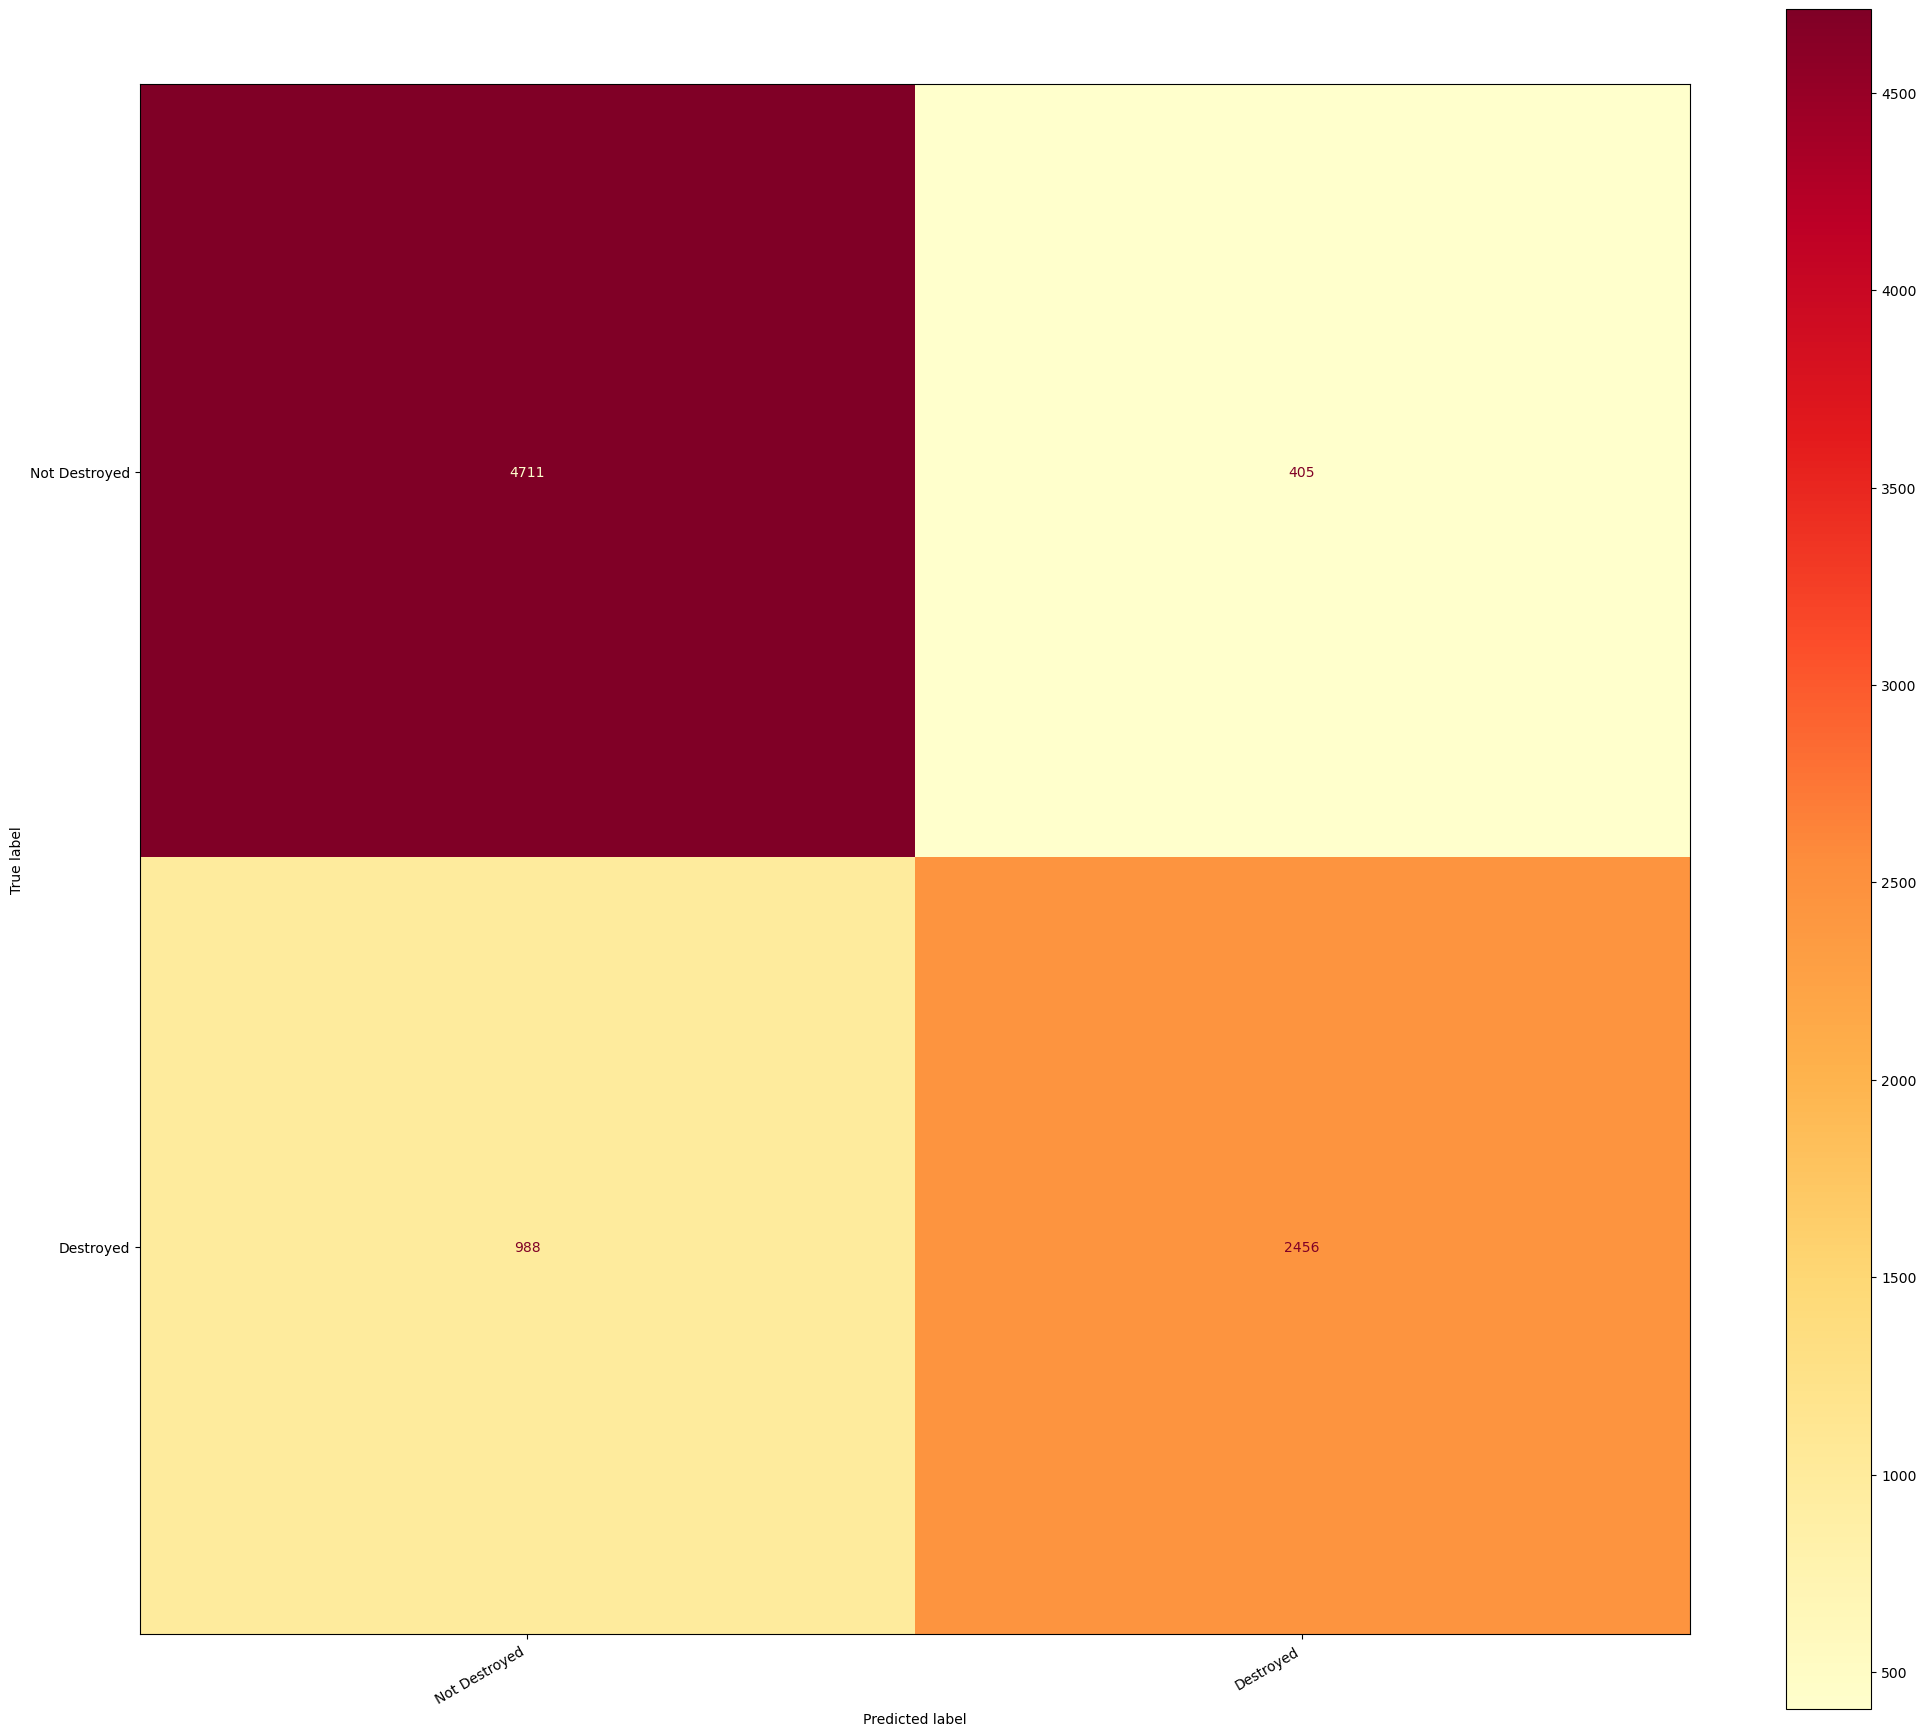

In [314]:
cm = confusion_matrix(fire_test.Destroyed, lr.predict(fire_test[features]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(25, 25))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.show()
